## Comparing Wind Power ##

we have two wind power datasets:

1. Obs data from ERA5 conversion
2. Model data (first NDJFMAMJJASO) from HadGEM3-GC31-MM conversion

We want to compare the model demand data to the obs demand data to see how similar/different these are and visually assess whether we are getting similar(-ish) values. 

In [1]:
# cell magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load local modules
import os
import sys
import glob
import importlib

# Import external modules
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# tqdm for progress bars
from tqdm import tqdm

In [2]:
# Set up the global variables
dfs_dir = "/gws/nopw/j04/canari/users/benhutch/met_to_energy_dfs"

# model filename
model_wind_ons = "United_Kingdom_wind_power_df_test_ons_1960_2018_NDJFM.csv"
model_wind_ofs = "United_Kingdom_wind_power_df_test_ofs_1960_2018_NDJFM.csv"

# obs filename
obs_wind_ons = "United_Kingdom_obs_wind_speed_cfs_ons.csv"
obs_wind_ofs = "United_Kingdom_obs_wind_speed_cfs_ofs.csv"

In [3]:
# Set up the values of installed capacities in 2023
# Make some assumptions about the power system
# wind power capacity factors - includes both onshore and offshore?
# also I guess power system is 2021 ish set up?
# although won't have changed significantly since then
# Not sure how accurate these are leached from:
# https://windeurope.org/intelligence-platform/product/wind-energy-in-europe-2023-statistics-and-the-outlook-for-2024-2030/
installed_ofs_2023 = 14.756  # GW
installed_ons_2023 = 14.866  # GW

In [4]:
# Load the data
model_wind_ons_df = pd.read_csv(os.path.join(dfs_dir, model_wind_ons))
model_wind_ofs_df = pd.read_csv(os.path.join(dfs_dir, model_wind_ofs))

obs_wind_ons_df = pd.read_csv(os.path.join(dfs_dir, obs_wind_ons))
obs_wind_ofs_df = pd.read_csv(os.path.join(dfs_dir, obs_wind_ofs))

In [5]:
model_wind_ons_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ons
0,1960,1,1,0.682444
1,1960,1,2,0.681283
2,1960,1,3,0.684550
3,1960,1,4,0.687110
4,1960,1,5,0.685891


In [6]:
model_wind_ofs_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ofs
0,1960,1,1,0.800509
1,1960,1,2,0.800961
2,1960,1,3,0.800905
3,1960,1,4,0.803976
4,1960,1,5,0.802065


In [7]:
obs_wind_ons_df.head()

,time,obs_wind_speed_100m_bc,obs_cfs_ons
0,1960-11-01,11.325152,0.699079
1,1960-11-02,14.248714,0.804985
2,1960-11-03,10.112684,0.553986
3,1960-11-04,8.534932,0.419052
4,1960-11-05,7.439478,0.249140


In [8]:
obs_wind_ofs_df.head()

,time,obs_wind_speed_100m_bc,obs_cfs_ofs
0,1960-11-01,11.325152,0.826896
1,1960-11-02,14.248714,0.874877
2,1960-11-03,10.112684,0.661860
3,1960-11-04,8.534932,0.496145
4,1960-11-05,7.439478,0.326865


In [9]:
# Combine the two model dataframes
model_wind_df = pd.concat([model_wind_ons_df, model_wind_ofs_df], axis=1)

In [10]:
# remove duplicate columns
model_wind_df = model_wind_df.loc[:, ~model_wind_df.columns.duplicated()]

In [11]:
model_wind_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs
0,1960,1,1,0.682444,0.800509
1,1960,1,2,0.681283,0.800961
2,1960,1,3,0.684550,0.800905
3,1960,1,4,0.687110,0.803976
4,1960,1,5,0.685891,0.802065


In [12]:
# Combine the two obs dataframes
obs_wind_df = pd.concat([obs_wind_ons_df, obs_wind_ofs_df], axis=1)

In [13]:
# remove duplicate columns
obs_wind_df = obs_wind_df.loc[:, ~obs_wind_df.columns.duplicated()]

In [14]:
# ensure that time is datetime
obs_wind_df["time"] = pd.to_datetime(obs_wind_df["time"])

# set time as the index
obs_wind_df.set_index("time", inplace=True)

# remove the name of the index
obs_wind_df.index.name = None

In [109]:
obs_wind_df.tail()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen
2019-10-26,8.963854,0.433389,0.526947,6.442756,7.775625
2019-10-27,8.090914,0.350192,0.440908,5.205961,6.506038
2019-10-28,5.917435,0.130706,0.166644,1.943073,2.458993
2019-10-29,6.954676,0.249356,0.312611,3.706926,4.612892
2019-10-30,7.278067,0.285682,0.361351,4.246947,5.332090


In [111]:
# save the data
save_dir = "/home/users/benhutch/unseen_multi_year/dfs"

# set up the fname
fname = "United_Kingdom_wind_power_df_test_ons_ofs_1960_2018_NDJFM_obs.csv"

# save the data
obs_wind_df.to_csv(os.path.join(save_dir, fname))

In [16]:
model_wind_df.head()

,init,lead,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs
0,1960,1,1,0.682444,0.800509
1,1960,1,2,0.681283,0.800961
2,1960,1,3,0.684550,0.800905
3,1960,1,4,0.687110,0.803976
4,1960,1,5,0.685891,0.802065


In [17]:
# compute the onshore wind power and offshore wind power
model_wind_df["ons_gen"] = (
    model_wind_df["United_Kingdom_wind_power_cfs_ons"] * installed_ons_2023
)
model_wind_df["ofs_gen"] = (
    model_wind_df["United_Kingdom_wind_power_cfs_ofs"] * installed_ofs_2023
)

obs_wind_df["ons_gen"] = obs_wind_df["obs_cfs_ons"] * installed_ons_2023
obs_wind_df["ofs_gen"] = obs_wind_df["obs_cfs_ofs"] * installed_ofs_2023

In [18]:
# constrain the obs wind df to NDJFM
obs_wind_df_NDJFM = obs_wind_df.loc[obs_wind_df.index.month.isin([11, 12, 1, 2, 3])]

# shift back by 3 months and take the annual mean
obs_wind_df_NDJFM = obs_wind_df_NDJFM.shift(-3).resample("Y").mean()

In [19]:
#  set the index to just be years
obs_wind_df_NDJFM.index = obs_wind_df_NDJFM.index.year

In [20]:
obs_wind_df_NDJFM.head()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen
1960,7.615372,0.317502,0.386287,4.719981,5.700048
1961,7.769681,0.332331,0.406113,4.940427,5.992599
1962,8.186395,0.368682,0.445239,5.480823,6.569943
1963,7.548107,0.308328,0.376753,4.583609,5.559361
1964,7.541095,0.310456,0.378537,4.615244,5.585694


In [107]:
model_wind_df.tail()

,init,lead,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs,ons_gen,ofs_gen
88495,2018,150,6,0.110222,0.133119,1.638565,1.964298
88496,2018,150,7,0.262335,0.337312,3.899873,4.977373
88497,2018,150,8,0.220575,0.277193,3.279068,4.090260
88498,2018,150,9,0.622080,0.736567,9.247848,10.868786
88499,2018,150,10,0.330412,0.408808,4.911898,6.032373


In [108]:
# set up the save_dir
save_dir = "/home/users/benhutch/unseen_multi_year/dfs"

# set up the fname
fname = "United_Kingdom_wind_power_df_test_ons_ofs_1960_2018_NDJFM.csv"

# save the data
model_wind_df.to_csv(os.path.join(save_dir, fname))

In [22]:
# do the same for the model data
model_wind_df_NDJFM = pd.DataFrame()

# loop over the unique inits in the model data
for init in model_wind_df["init"].unique():
    # constrain to the current init
    model_wind_init = model_wind_df.loc[model_wind_df["init"] == init]
    # loop over the unique members in the model data
    for member in model_wind_init["member"].unique():
        # constrain to the current member
        model_wind_member = model_wind_init.loc[model_wind_init["member"] == member]

        # Take the mean over leads 1-150
        model_wind_member_mean = (
            model_wind_member[model_wind_member["lead"].isin(range(1, 151))]
            .groupby(["init", "member"])
            .mean()
        )

        # add the mean to the model_demand_NDJFM dataframe
        model_wind_df_NDJFM = pd.concat([model_wind_df_NDJFM, model_wind_member_mean])

# reset the index
model_wind_df_NDJFM.reset_index(inplace=True)

# convert init to datetime format
model_wind_df_NDJFM["init"] = pd.to_datetime(model_wind_df_NDJFM["init"], format="%Y")

# set the index to be the init
model_wind_df_NDJFM.set_index("init", inplace=True)

# remove the name of the index
model_wind_df_NDJFM.index.name = None

# remove the lead column
model_wind_df_NDJFM.drop(columns="lead", inplace=True)

In [23]:
model_wind_df_NDJFM

,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs,ons_gen,ofs_gen
1960-01-01,1,0.302699,0.366917,4.499927,5.414228
1960-01-01,2,0.268961,0.326913,3.998380,4.823929
1960-01-01,3,0.329829,0.397164,4.903244,5.860547
1960-01-01,4,0.269520,0.327850,4.006691,4.837756
1960-01-01,5,0.275900,0.332092,4.101528,4.900346
...,...,...,...,...,...
2018-01-01,6,0.304481,0.371643,4.526413,5.483965
2018-01-01,7,0.240862,0.295463,3.580652,4.359856
2018-01-01,8,0.236120,0.290004,3.510161,4.279304
2018-01-01,9,0.282167,0.343250,4.194696,5.065000


In [24]:
# format the idnex as %Y
model_wind_df_NDJFM.index = model_wind_df_NDJFM.index.strftime("%Y")

In [25]:
model_wind_df_NDJFM.head()

,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs,ons_gen,ofs_gen
1960,1,0.302699,0.366917,4.499927,5.414228
1960,2,0.268961,0.326913,3.998380,4.823929
1960,3,0.329829,0.397164,4.903244,5.860547
1960,4,0.269520,0.327850,4.006691,4.837756
1960,5,0.275900,0.332092,4.101528,4.900346


In [26]:
obs_wind_df_NDJFM.tail()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen
2015,9.384046,0.479497,0.567483,7.128205,8.373778
2016,7.902584,0.342007,0.413811,5.084275,6.106196
2017,8.054294,0.351632,0.430855,5.227360,6.357702
2018,8.238295,0.369569,0.450587,5.494008,6.648858
2019,8.165322,0.365757,0.442185,5.437338,6.524888


Text(0, 0.5, 'Onshore Wind Generation (GW)')

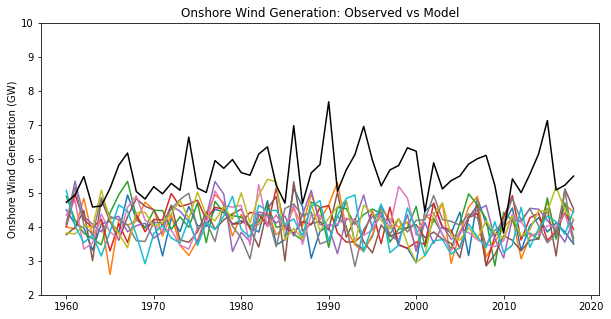

In [27]:
# set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# # # # # plot the observed data
# obs_wind_df_NDJFM["ons_gen"][:-1].plot(label="Observed", ax=ax, color="black")

# set up the index from obs
index = obs_wind_df_NDJFM["ons_gen"][:-1].index

# # print the min index of the obs data
# print(obs_wind_df_NDJFM["ons_gen"][:-1].index.min())
# print(obs_wind_df_NDJFM["ons_gen"][:-1].index.max())

# loop over the unique members
for member in model_wind_df_NDJFM["member"].unique():
    # plot the model data
    model_wind_df_NDJFM_member = model_wind_df_NDJFM.loc[
        model_wind_df_NDJFM["member"] == member
    ]

    # extract the values
    values = model_wind_df_NDJFM_member["ons_gen"].values

    # # print the min index of the model data
    # print(model_wind_df_NDJFM_member.index.min())
    # print(model_wind_df_NDJFM_member.index.max())

    # plot the model data
    plt.plot(index, values, label=f"Model Member {member}")

# extract the observed values
obs_values = obs_wind_df_NDJFM["ons_gen"][:-1].values

# plot the observed data
plt.plot(index, obs_values, label="Observed", color="black")

# set constant ylims
ax.set_ylim(2, 10)

# set the title
plt.title("Onshore Wind Generation: Observed vs Model")

# set the ylabel
plt.ylabel("Onshore Wind Generation (GW)")

Text(0, 0.5, 'Offshore Wind Generation (GW)')

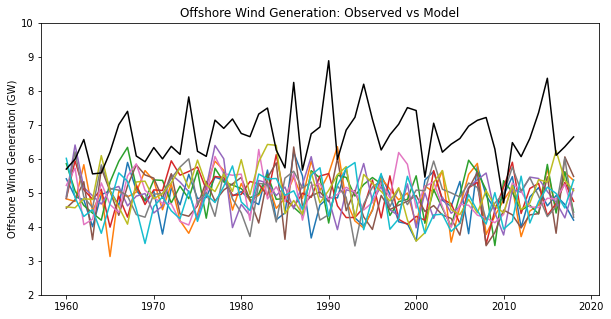

In [28]:
# same but for offshore
fig, ax = plt.subplots(figsize=(10, 5))

# Set up the index from ths obs
index = obs_wind_df_NDJFM["ofs_gen"][:-1].index

# loop over the unique members
for member in model_wind_df_NDJFM["member"].unique():
    # plot the model data
    model_wind_df_NDJFM_member = model_wind_df_NDJFM.loc[
        model_wind_df_NDJFM["member"] == member
    ]

    # extract the values
    values = model_wind_df_NDJFM_member["ofs_gen"].values

    # plot the model data
    plt.plot(index, values, label=f"Model Member {member}")

# extract the observed values
obs_values = obs_wind_df_NDJFM["ofs_gen"][:-1].values

# plot the observed data
plt.plot(index, obs_values, label="Observed", color="black")

# set constant ylims
ax.set_ylim(2, 10)

# set the title
plt.title("Offshore Wind Generation: Observed vs Model")

# set the ylabel
plt.ylabel("Offshore Wind Generation (GW)")

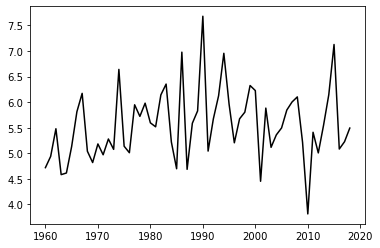

In [29]:
plt.plot(
    obs_wind_df_NDJFM["ons_gen"][:-1].index,
    obs_wind_df_NDJFM["ons_gen"][:-1],
    color="black",
    label="Observed",
)
# plt.plot(model_wind_df_NDJFM.index, model_wind_df_NDJFM["ons_gen"], color="blue", label="Model")

In [30]:
model_wind_df_NDJFM_member["ons_gen"]

1960    5.074840
1961    4.030969
1962    3.529285
1963    3.769505
1964    3.141721
1965    3.859272
1966    4.648751
1967    4.463926
1968    3.769014
1969    2.914474
1970    3.804104
1971    4.043195
1972    3.673842
1973    3.523559
1974    4.213163
1975    3.452666
1976    4.115779
1977    3.919505
1978    4.315065
1979    4.896411
1980    3.922020
1981    3.702424
1982    4.635720
1983    4.471995
1984    4.487474
1985    4.067733
1986    4.233627
1987    3.737155
1988    4.602245
1989    4.777130
1990    3.576425
1991    4.324472
1992    4.835345
1993    4.937389
1994    3.265090
1995    4.039668
1996    4.674384
1997    3.237771
1998    3.460312
1999    4.557399
2000    3.936089
2001    3.146606
2002    3.586984
2003    3.625721
2004    3.198502
2005    3.397421
2006    4.083545
2007    3.709282
2008    3.388035
2009    4.152065
2010    3.244437
2011    3.466994
2012    4.577195
2013    3.397491
2014    3.948849
2015    4.317932
2016    4.149269
2017    3.782355
2018    4.4863

In [31]:
# print the len of the obs data
print(len(obs_wind_df_NDJFM))

60


Text(0.5, 1.0, 'Onshore Wind Generation: Observed vs Model Histograms')

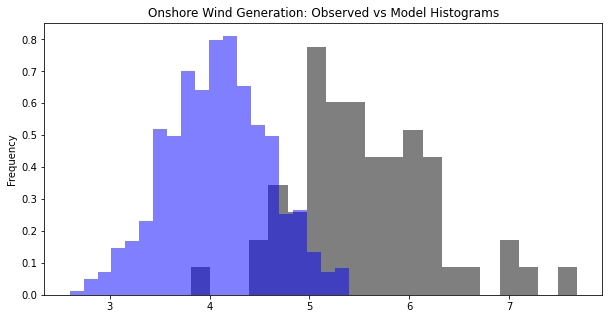

In [32]:
# Plot the histograms of the observed wind and the model winds
fig, ax = plt.subplots(figsize=(10, 5))

# plot the histogram of the observed data
obs_wind_df_NDJFM["ons_gen"].plot.hist(
    ax=ax, bins=20, alpha=0.5, label="Observed", color="black", density=True
)

# loop over the unique members
model_wind_df_NDJFM["ons_gen"].plot.hist(
    ax=ax, bins=20, alpha=0.5, label="Model", color="blue", density=True
)

# set the title
plt.title("Onshore Wind Generation: Observed vs Model Histograms")

Text(0.5, 1.0, 'Offshore Wind Generation: Observed vs Model Histograms')

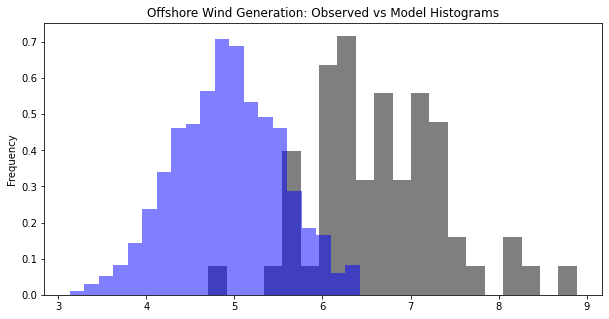

In [33]:
fig, ax = plt.subplots(figsize=(10, 5))

# plot the histogram of the observed data
obs_wind_df_NDJFM["ofs_gen"].plot.hist(
    ax=ax, bins=20, alpha=0.5, label="Observed", color="black", density=True
)

# loop over the unique members
model_wind_df_NDJFM["ofs_gen"].plot.hist(
    ax=ax, bins=20, alpha=0.5, label="Model", color="blue", density=True
)

# set the title
plt.title("Offshore Wind Generation: Observed vs Model Histograms")

In [34]:
# calculate the ons_gen_anom and ofs_gen_anom
obs_wind_df_NDJFM["ons_gen_anom"] = (
    obs_wind_df_NDJFM["ons_gen"] - obs_wind_df_NDJFM["ons_gen"].mean()
)

obs_wind_df_NDJFM["ofs_gen_anom"] = (
    obs_wind_df_NDJFM["ofs_gen"] - obs_wind_df_NDJFM["ofs_gen"].mean()
)

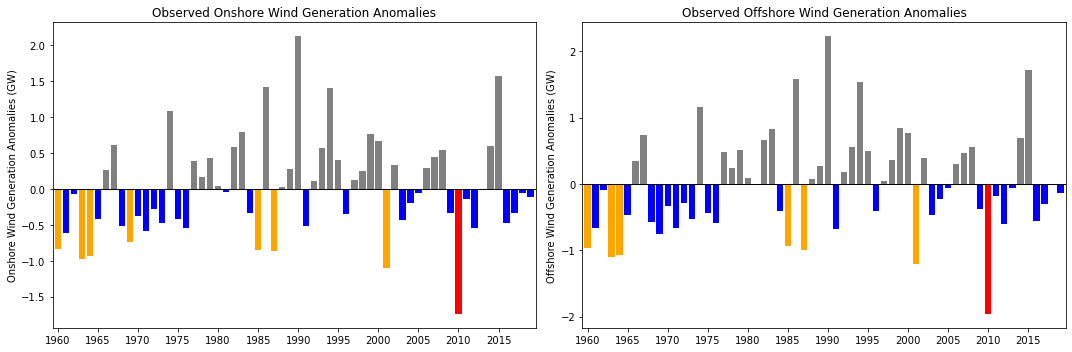

In [35]:
# Set up the negative conditions for the onshore wind
negative_conditions_wind_ons_obs = [
    (
        (obs_wind_df_NDJFM["ons_gen_anom"] < 0)
        & (
            obs_wind_df_NDJFM["ons_gen_anom"]
            > -1 * np.std(obs_wind_df_NDJFM["ons_gen_anom"])
        )
    ),
    (
        (
            obs_wind_df_NDJFM["ons_gen_anom"]
            < -1 * np.std(obs_wind_df_NDJFM["ons_gen_anom"])
        )
        & (
            obs_wind_df_NDJFM["ons_gen_anom"]
            > -2 * np.std(obs_wind_df_NDJFM["ons_gen_anom"])
        )
    ),
    (
        (
            obs_wind_df_NDJFM["ons_gen_anom"]
            < -2 * np.std(obs_wind_df_NDJFM["ons_gen_anom"])
        )
        & (
            obs_wind_df_NDJFM["ons_gen_anom"]
            > -3 * np.std(obs_wind_df_NDJFM["ons_gen_anom"])
        )
    ),
    (
        obs_wind_df_NDJFM["ons_gen_anom"]
        < -3 * np.std(obs_wind_df_NDJFM["ons_gen_anom"])
    ),
    (obs_wind_df_NDJFM["ons_gen_anom"] > 0),
]

negative_conditions_wind_ofs_obs = [
    (
        (obs_wind_df_NDJFM["ofs_gen_anom"] < 0)
        & (
            obs_wind_df_NDJFM["ofs_gen_anom"]
            > -1 * np.std(obs_wind_df_NDJFM["ofs_gen_anom"])
        )
    ),
    (
        (
            obs_wind_df_NDJFM["ofs_gen_anom"]
            < -1 * np.std(obs_wind_df_NDJFM["ofs_gen_anom"])
        )
        & (
            obs_wind_df_NDJFM["ofs_gen_anom"]
            > -2 * np.std(obs_wind_df_NDJFM["ofs_gen_anom"])
        )
    ),
    (
        (
            obs_wind_df_NDJFM["ofs_gen_anom"]
            < -2 * np.std(obs_wind_df_NDJFM["ofs_gen_anom"])
        )
        & (
            obs_wind_df_NDJFM["ofs_gen_anom"]
            > -3 * np.std(obs_wind_df_NDJFM["ofs_gen_anom"])
        )
    ),
    (
        obs_wind_df_NDJFM["ofs_gen_anom"]
        < -3 * np.std(obs_wind_df_NDJFM["ofs_gen_anom"])
    ),
    (obs_wind_df_NDJFM["ofs_gen_anom"] > 0),
]

# set up the colours for these
colors = ["blue", "orange", "red", "purple", "gray"]

# set up the labels for these
obs_wind_df_NDJFM["colour_ons"] = np.select(
    negative_conditions_wind_ons_obs, colors, default="black"
)
obs_wind_df_NDJFM["colour_ofs"] = np.select(
    negative_conditions_wind_ofs_obs, colors, default="black"
)

# set up a subplots with one row and two columns
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# plot the observed data as bars
obs_wind_df_NDJFM["ons_gen_anom"].plot.bar(
    ax=axs[0], color=obs_wind_df_NDJFM["colour_ons"], label="Observed", width=0.8
)
obs_wind_df_NDJFM["ofs_gen_anom"].plot.bar(
    ax=axs[1], color=obs_wind_df_NDJFM["colour_ofs"], label="Observed", width=0.8
)

# set up a horizontal line at 0
axs[0].axhline(0, color="black", linewidth=1)
axs[1].axhline(0, color="black", linewidth=1)

# set the title
axs[0].set_title("Observed Onshore Wind Generation Anomalies")
axs[1].set_title("Observed Offshore Wind Generation Anomalies")

# only plo the xlabels every 5 years
axs[0].set_xticks(axs[0].get_xticks()[::5])
axs[1].set_xticks(axs[1].get_xticks()[::5])

# tilt the ticks to make them more readable
axs[0].tick_params(axis="x", rotation=360)
axs[1].tick_params(axis="x", rotation=360)

# set the ylabel
axs[0].set_ylabel("Onshore Wind Generation Anomalies (GW)")
axs[1].set_ylabel("Offshore Wind Generation Anomalies (GW)")

# Set up a tight layout
plt.tight_layout()

In [36]:
# new column
obs_wind_df_NDJFM["total_gen"] = (
    obs_wind_df_NDJFM["ons_gen"] + obs_wind_df_NDJFM["ofs_gen"]
)

In [37]:
# new column for standardised total generation
obs_wind_df_NDJFM["total_gen_anom"] = (
    obs_wind_df_NDJFM["total_gen"] - obs_wind_df_NDJFM["total_gen"].mean()
) / obs_wind_df_NDJFM["total_gen"].std()

Text(0, 0.5, 'Total Wind Generation Anomalies')

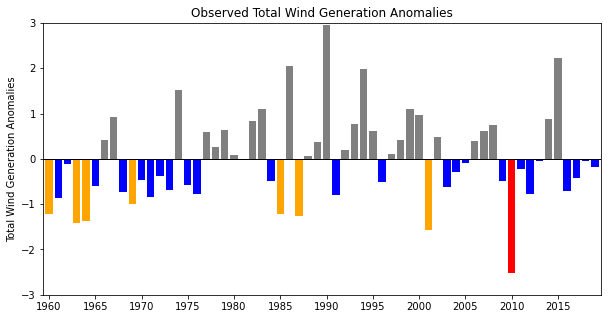

In [38]:
# set up the negative conditions for total gen standardised anomalies
negative_conditions_wind_total_obs = [
    (
        (obs_wind_df_NDJFM["total_gen_anom"] < 0)
        & (obs_wind_df_NDJFM["total_gen_anom"] > -1)
    ),
    (
        (obs_wind_df_NDJFM["total_gen_anom"] < -1)
        & (obs_wind_df_NDJFM["total_gen_anom"] > -2)
    ),
    (
        (obs_wind_df_NDJFM["total_gen_anom"] < -2)
        & (obs_wind_df_NDJFM["total_gen_anom"] > -3)
    ),
    (obs_wind_df_NDJFM["total_gen_anom"] < -3),
    (obs_wind_df_NDJFM["total_gen_anom"] > 0),
]

# set up the colours for these
colors = ["blue", "orange", "red", "purple", "gray"]

# set up the labels for these
obs_wind_df_NDJFM["colour_total"] = np.select(
    negative_conditions_wind_total_obs, colors, default="black"
)

# set the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the observed data as bars
obs_wind_df_NDJFM["total_gen_anom"].plot.bar(
    ax=ax, color=obs_wind_df_NDJFM["colour_total"], label="Observed", width=0.8
)

# set up a horizontal line at 0
ax.axhline(0, color="black", linewidth=1)

# set the title
plt.title("Observed Total Wind Generation Anomalies")

# only plo the xlabels every 5 years
ax.set_xticks(ax.get_xticks()[::5])

# tilt the ticks to make them more readable
ax.tick_params(axis="x", rotation=360)

# set the ylmis
ax.set_ylim(-3, 3)

# set the ylabel
plt.ylabel("Total Wind Generation Anomalies")

In [39]:
model_wind_df_NDJFM.head()

,member,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs,ons_gen,ofs_gen
1960,1,0.302699,0.366917,4.499927,5.414228
1960,2,0.268961,0.326913,3.998380,4.823929
1960,3,0.329829,0.397164,4.903244,5.860547
1960,4,0.269520,0.327850,4.006691,4.837756
1960,5,0.275900,0.332092,4.101528,4.900346


In [40]:
# quantify onshore wind generation anomalies
model_wind_df_NDJFM["ons_gen_anom"] = (
    model_wind_df_NDJFM["ons_gen"] - model_wind_df_NDJFM["ons_gen"].mean()
)
model_wind_df_NDJFM["ofs_gen_anom"] = (
    model_wind_df_NDJFM["ofs_gen"] - model_wind_df_NDJFM["ofs_gen"].mean()
)

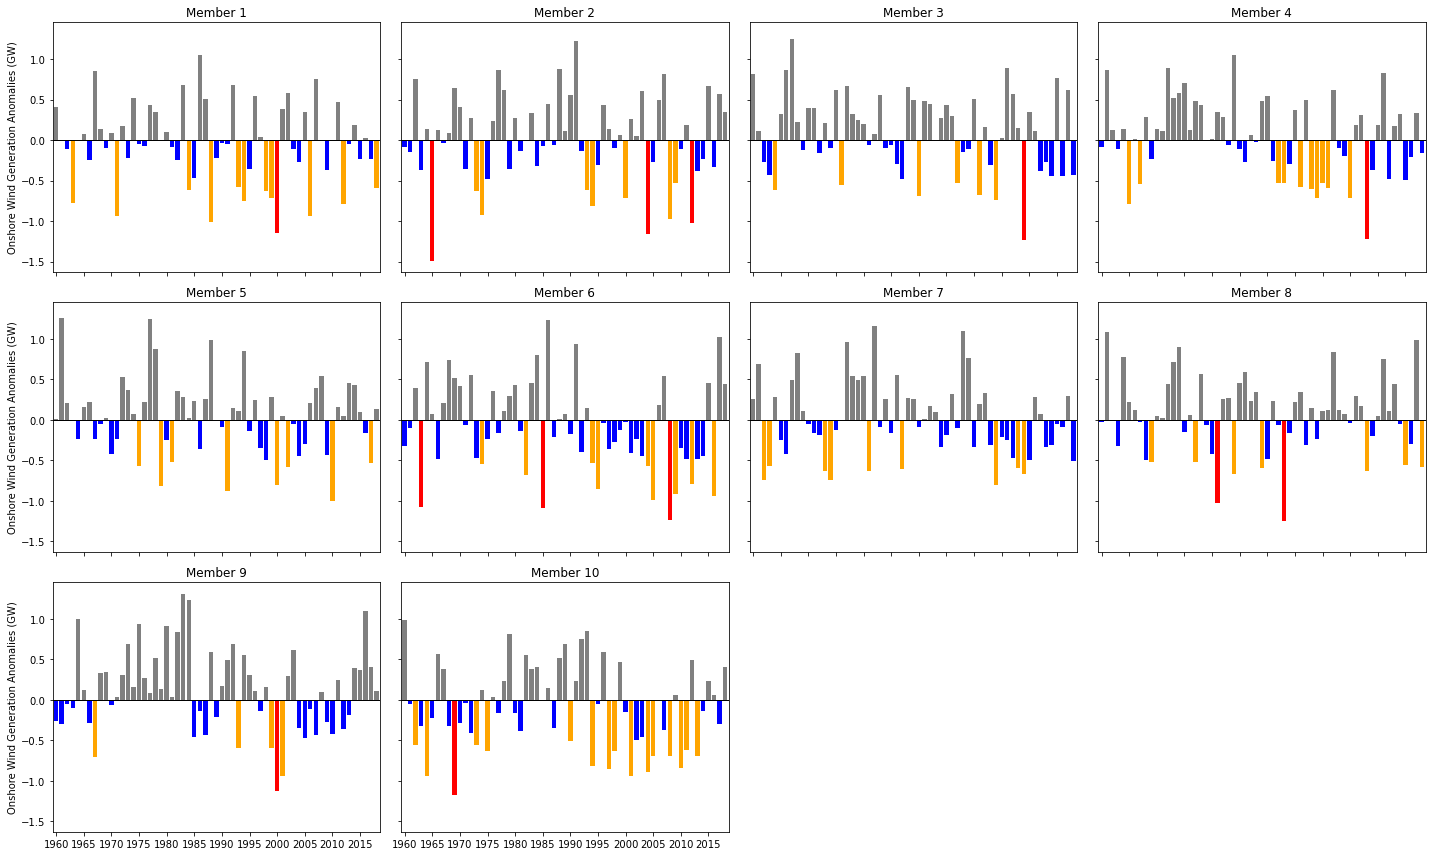

In [41]:
# plot the onshore wind generation anomalies for the model
# for each member
negative_conditions_wind_ons_model = [
    (
        (model_wind_df_NDJFM["ons_gen_anom"] < 0)
        & (
            model_wind_df_NDJFM["ons_gen_anom"]
            > -1 * np.std(model_wind_df_NDJFM["ons_gen_anom"])
        )
    ),
    (
        (
            model_wind_df_NDJFM["ons_gen_anom"]
            < -1 * np.std(model_wind_df_NDJFM["ons_gen_anom"])
        )
        & (
            model_wind_df_NDJFM["ons_gen_anom"]
            > -2 * np.std(model_wind_df_NDJFM["ons_gen_anom"])
        )
    ),
    (
        (
            model_wind_df_NDJFM["ons_gen_anom"]
            < -2 * np.std(model_wind_df_NDJFM["ons_gen_anom"])
        )
        & (
            model_wind_df_NDJFM["ons_gen_anom"]
            > -3 * np.std(model_wind_df_NDJFM["ons_gen_anom"])
        )
    ),
    (
        model_wind_df_NDJFM["ons_gen_anom"]
        < -3 * np.std(model_wind_df_NDJFM["ons_gen_anom"])
    ),
    (model_wind_df_NDJFM["ons_gen_anom"] > 0),
]

# Set up the colours for these
model_wind_df_NDJFM["colour_ons"] = np.select(
    negative_conditions_wind_ons_model, colors, default="black"
)

# Set up the figure with 3 rows and 4 columns
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)

# Loop over the unique members in the model data
for member, ax in zip(model_wind_df_NDJFM["member"].unique(), axs.flatten()):
    # plot the onshore wind generation anomalies
    model_wind_df_NDJFM_member = model_wind_df_NDJFM.loc[
        model_wind_df_NDJFM["member"] == member
    ]

    # plot the observed data as bars
    model_wind_df_NDJFM_member["ons_gen_anom"].plot.bar(
        ax=ax,
        color=model_wind_df_NDJFM_member["colour_ons"],
        label=f"Model Member {member}",
        width=0.8,
    )

    # set up a horizontal line at 0
    ax.axhline(0, color="black", linewidth=1)

    # set the title
    ax.set_title(f"Member {member}")

    # only plo the xlabels every 5 years
    ax.set_xticks(ax.get_xticks()[::5])

    # tilt the ticks to make them more readable
    ax.tick_params(axis="x", rotation=360)

    # set the ylabel
    ax.set_ylabel("Onshore Wind Generation Anomalies (GW)")

# remove the subplots that are not used
for ax in axs.flatten()[len(model_wind_df_NDJFM["member"].unique()) :]:
    fig.delaxes(ax)

# Specify a tight layout
plt.tight_layout()

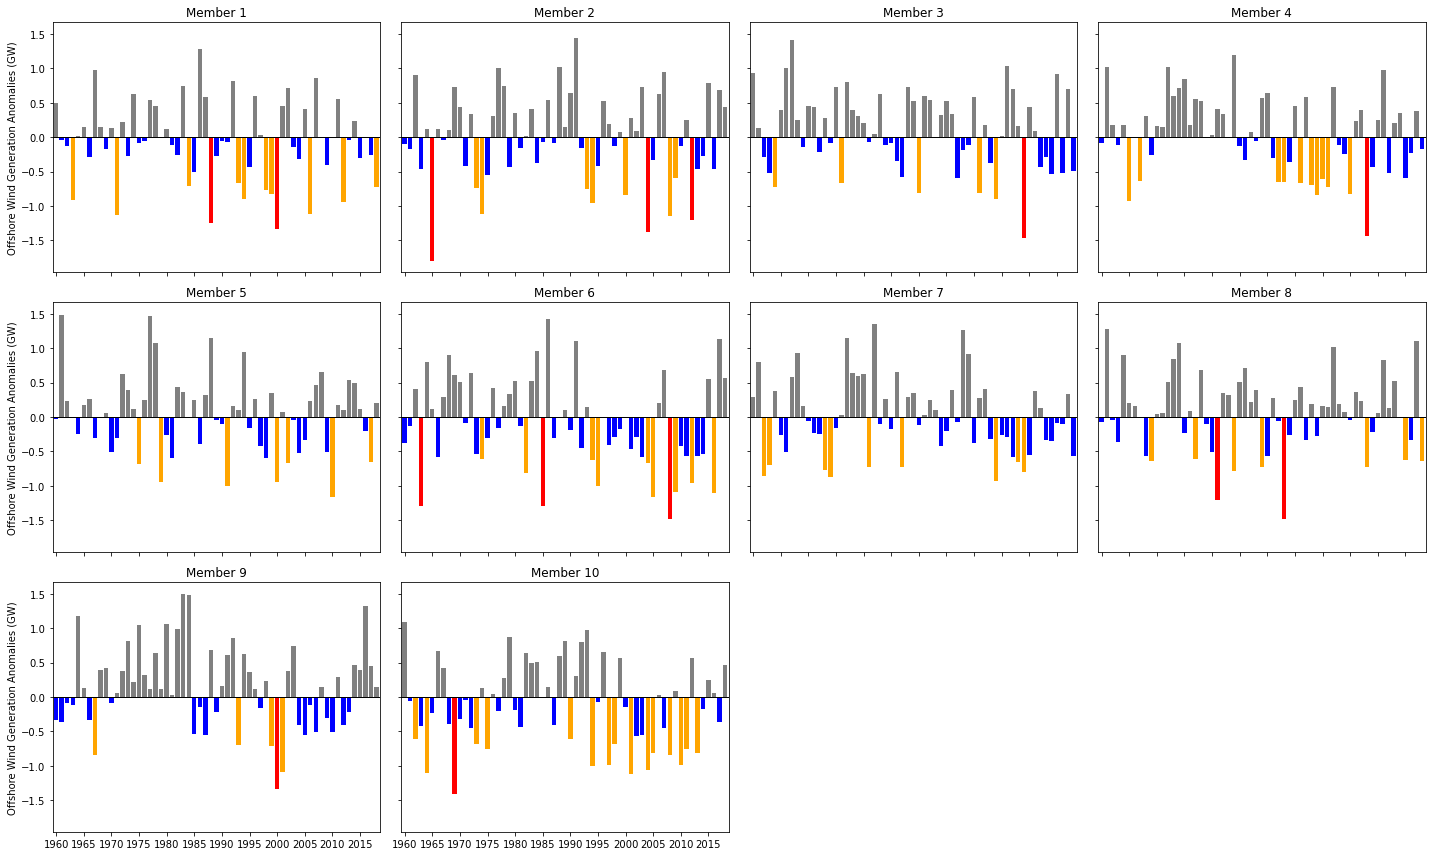

In [42]:
# set up the negatie conditions for the offshore wind
negative_conditions_wind_ofs_model = [
    (
        (model_wind_df_NDJFM["ofs_gen_anom"] < 0)
        & (
            model_wind_df_NDJFM["ofs_gen_anom"]
            > -1 * np.std(model_wind_df_NDJFM["ofs_gen_anom"])
        )
    ),
    (
        (
            model_wind_df_NDJFM["ofs_gen_anom"]
            < -1 * np.std(model_wind_df_NDJFM["ofs_gen_anom"])
        )
        & (
            model_wind_df_NDJFM["ofs_gen_anom"]
            > -2 * np.std(model_wind_df_NDJFM["ofs_gen_anom"])
        )
    ),
    (
        (
            model_wind_df_NDJFM["ofs_gen_anom"]
            < -2 * np.std(model_wind_df_NDJFM["ofs_gen_anom"])
        )
        & (
            model_wind_df_NDJFM["ofs_gen_anom"]
            > -3 * np.std(model_wind_df_NDJFM["ofs_gen_anom"])
        )
    ),
    (
        model_wind_df_NDJFM["ofs_gen_anom"]
        < -3 * np.std(model_wind_df_NDJFM["ofs_gen_anom"])
    ),
    (model_wind_df_NDJFM["ofs_gen_anom"] > 0),
]

# Set up the colours for these
model_wind_df_NDJFM["colour_ofs"] = np.select(
    negative_conditions_wind_ofs_model, colors, default="black"
)

# Set up the figure with 3 rows and 4 columns
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)

# Loop over the unique members in the model data
for member, ax in zip(model_wind_df_NDJFM["member"].unique(), axs.flatten()):
    # plot the onshore wind generation anomalies
    model_wind_df_NDJFM_member = model_wind_df_NDJFM.loc[
        model_wind_df_NDJFM["member"] == member
    ]

    # plot the observed data as bars
    model_wind_df_NDJFM_member["ofs_gen_anom"].plot.bar(
        ax=ax,
        color=model_wind_df_NDJFM_member["colour_ofs"],
        label=f"Model Member {member}",
        width=0.8,
    )

    # set up a horizontal line at 0
    ax.axhline(0, color="black", linewidth=1)

    # set the title
    ax.set_title(f"Member {member}")

    # only plo the xlabels every 5 years
    ax.set_xticks(ax.get_xticks()[::5])

    # tilt the ticks to make them more readable
    ax.tick_params(axis="x", rotation=360)

    # set the ylabel
    ax.set_ylabel("Offshore Wind Generation Anomalies (GW)")

# remove the subplots that are not used
for ax in axs.flatten()[len(model_wind_df_NDJFM["member"].unique()) :]:
    fig.delaxes(ax)

# Specify a tight layout
plt.tight_layout()

In [43]:
# quantify the total generation for the model
model_wind_df_NDJFM["total_gen"] = (
    model_wind_df_NDJFM["ons_gen"] + model_wind_df_NDJFM["ofs_gen"]
)

In [44]:
# standardise the total generation anomalies
model_wind_df_NDJFM["total_gen_anom"] = (
    model_wind_df_NDJFM["total_gen"] - model_wind_df_NDJFM["total_gen"].mean()
) / model_wind_df_NDJFM["total_gen"].std()

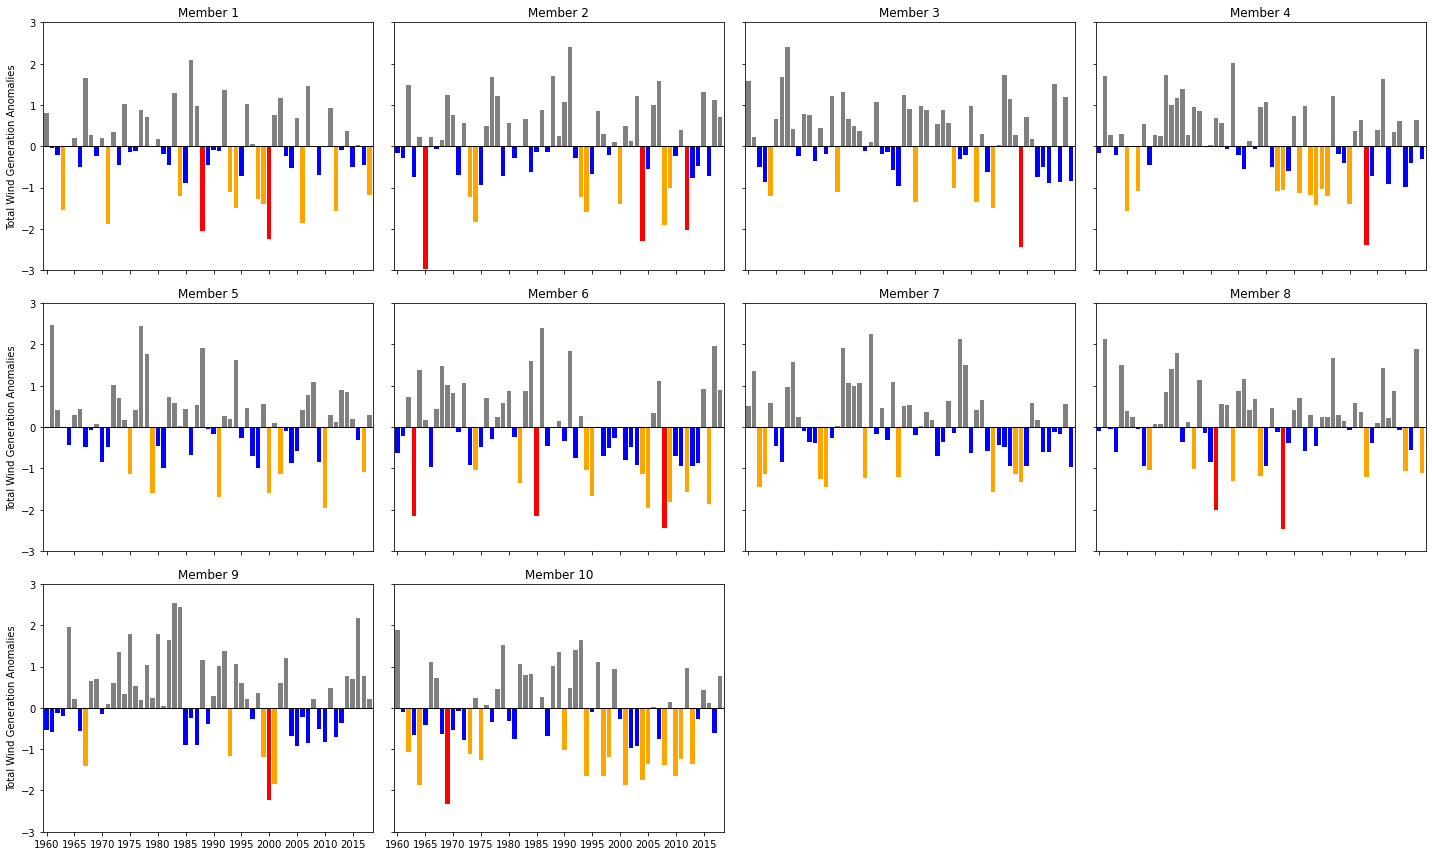

In [45]:
# set up the negative conditions for standardised total generation anomalies
negative_conditions_wind_total_model = [
    (
        (model_wind_df_NDJFM["total_gen_anom"] < 0)
        & (model_wind_df_NDJFM["total_gen_anom"] > -1)
    ),
    (
        (model_wind_df_NDJFM["total_gen_anom"] < -1)
        & (model_wind_df_NDJFM["total_gen_anom"] > -2)
    ),
    (
        (model_wind_df_NDJFM["total_gen_anom"] < -2)
        & (model_wind_df_NDJFM["total_gen_anom"] > -3)
    ),
    (model_wind_df_NDJFM["total_gen_anom"] < -3),
    (model_wind_df_NDJFM["total_gen_anom"] > 0),
]

# Set up the labels for these
model_wind_df_NDJFM["colour_total"] = np.select(
    negative_conditions_wind_total_model, colors, default="black"
)

# Set up the figure
fig, axs = plt.subplots(3, 4, figsize=(20, 12), sharex=True, sharey=True)

# Loop over the unique members in the model data
for member, ax in zip(model_wind_df_NDJFM["member"].unique(), axs.flatten()):
    # plot the total wind generation anomalies
    model_wind_df_NDJFM_member = model_wind_df_NDJFM.loc[
        model_wind_df_NDJFM["member"] == member
    ]

    # plot the observed data as bars
    model_wind_df_NDJFM_member["total_gen_anom"].plot.bar(
        ax=ax,
        color=model_wind_df_NDJFM_member["colour_total"],
        label=f"Model Member {member}",
        width=0.8,
    )

    # set up a horizontal line at 0
    ax.axhline(0, color="black", linewidth=1)

    # set the title
    ax.set_title(f"Member {member}")

    # only plo the xlabels every 5 years
    ax.set_xticks(ax.get_xticks()[::5])

    # tilt the ticks to make them more readable
    ax.tick_params(axis="x", rotation=360)

    # set the ylabel
    ax.set_ylabel("Total Wind Generation Anomalies")

    # set the ylims
    ax.set_ylim(-3, 3)

# remove the subplots that are not used
for ax in axs.flatten()[len(model_wind_df_NDJFM["member"].unique()) :]:
    fig.delaxes(ax)

# Specify a tight layout
plt.tight_layout()

In [46]:
# load in the demand data
model_demand_path = (
    "/home/users/benhutch/unseen_multi_year/dfs/model_demand_NDJFM_1960-2018.csv"
)
obs_demand_path = (
    "/home/users/benhutch/unseen_multi_year/dfs/obs_demand_NDJFM_1960-2018.csv"
)

# load the data
model_demand_df = pd.read_csv(model_demand_path)
obs_demand_df = pd.read_csv(obs_demand_path)

In [47]:
model_demand_df.head()

,Unnamed: 0,member,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960,r7i1p1f2,4.428282,11.071718,0.0,43.333399
1,1960,r1i1p1f2,5.206377,10.293623,0.0,42.751689
2,1960,r6i1p1f2,3.158589,12.341411,0.0,44.282633
3,1960,r2i1p1f2,4.630105,10.869895,0.0,43.182515
4,1960,r4i1p1f2,5.200538,10.299462,0.0,42.756054


In [48]:
obs_demand_df.head()

,Unnamed: 0,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
0,1960,4.710311,10.789689,0.0,43.122552
1,1961,4.666789,10.833211,0.0,43.155090
2,1962,3.104475,12.395525,0.0,44.323089
3,1963,1.975372,13.524628,0.0,45.167216
4,1964,3.774322,11.725678,0.0,43.822306


In [49]:
# Convert Unnamed: 0 to datetime
model_demand_df["Unnamed: 0"] = pd.to_datetime(
    model_demand_df["Unnamed: 0"], format="%Y"
)

# set this column as the index
model_demand_df.set_index("Unnamed: 0", inplace=True)

# Remove the name of the index
model_demand_df.index.name = None

In [50]:
# format the index as just years
model_demand_df.index = model_demand_df.index.strftime("%Y")

In [53]:
# strip strip r?i1p1f2 from member
# using re
# remove the first r and the last i1p1f2 from the member column
model_demand_df["member"] = model_demand_df["member"].str.replace(r"r", "")

In [54]:
# replace the i1p1f2 with nothing
model_demand_df["member"] = model_demand_df["member"].str.replace(r"i1p1f2", "")

In [55]:
# for the model_demand column
# order the member column in ascending order
# for each index
model_demand_df["member"] = model_demand_df["member"].astype(int)
model_demand_df = model_demand_df.groupby("member").apply(lambda x: x.sort_index())

In [56]:
model_demand_df.head()

,member,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
1960,1,5.206377,10.293623,0.0,42.751689
1960,2,4.630105,10.869895,0.0,43.182515
1960,3,4.810368,10.689632,0.0,43.047749
1960,4,5.200538,10.299462,0.0,42.756054
1960,5,5.778914,9.721086,0.0,42.323655


In [57]:
# Set 'member' and the index as the index for both dataframes
model_demand_df.set_index(["member"], append=True, inplace=True)
model_wind_df_NDJFM.set_index(["member"], append=True, inplace=True)

In [60]:
# # join the model_demand_df with the model_wind_df_NDJFM
# # Now you can join the dataframes
model_df = model_demand_df.join(model_wind_df_NDJFM)

In [61]:
model_df.head()

United_Kingdom_tas  United_Kingdom_hdd  United_Kingdom_cdd  \
     member                                                               
1960 1                 5.206377           10.293623                 0.0   
     2                 4.630105           10.869895                 0.0   
     3                 4.810368           10.689632                 0.0   
     4                 5.200538           10.299462                 0.0   
     5                 5.778914            9.721086                 0.0   

             United_Kingdom_demand  United_Kingdom_wind_power_cfs_ons  \
     member                                                             
1960 1                   42.751689                           0.302699   
     2                   43.182515                           0.268961   
     3                   43.047749                           0.329829   
     4                   42.756054                           0.269520   
     5                   42.323655                           0.275900   

             United_Kingdom_wind_power_cfs_ofs   ons_gen   ofs_gen  \
     member                                                          
1960 1                                0.366917  4.499927  5.414228   
     2                                0.326913  3.998380  4.823929   
     3                                0.397164  4.903244  5.860547   
     4                                0.327850  4.006691  4.837756   
     5                                0.332092  4.101528  4.900346   

             ons_gen_anom  ofs_gen_anom colour_ons colour_ofs  total_gen  \
     member                                                                
1960 1           0.412977      0.491481       gray       gray   9.914155   
     2          -0.088570     -0.098818       blue       blue   8.822308   
     3           0.816295      0.937799       gray       gray  10.763791   
     4          -0.080258     -0.084991       blue       blue   8.844447   
     5           0.014578     -0.022401       gray       blue   9.001874   

             total_gen_anom colour_total  
     member                               
1960 1             0.815762         gray  
     2            -0.169012         blue  
     3             1.582078         gray  
     4            -0.149044         blue  
     5            -0.007055         blue

In [70]:
obs_demand_df.tail()

,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand
2015,6.263203,9.236797,0.0,41.961596
2016,5.355942,10.144058,0.0,42.639872
2017,5.829278,9.670722,0.0,42.286002
2018,5.155643,10.344357,0.0,42.789618
2019,5.914487,9.585513,0.0,42.222300


In [63]:
# convert the time column to datetime
obs_demand_df["Unnamed: 0"] = pd.to_datetime(obs_demand_df["Unnamed: 0"], format="%Y")

# set this column as the index
obs_demand_df.set_index("Unnamed: 0", inplace=True)

# Remove the name of the index
obs_demand_df.index.name = None

In [65]:
# strftime the index
obs_demand_df.index = obs_demand_df.index.strftime("%Y")

In [71]:
obs_wind_df_NDJFM.tail()

,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen,ons_gen_anom,ofs_gen_anom,colour_ons,colour_ofs,total_gen,total_gen_anom,colour_total
2015,9.384046,0.479497,0.567483,7.128205,8.373778,1.572145,1.709900,gray,gray,15.501983,2.225427,gray
2016,7.902584,0.342007,0.413811,5.084275,6.106196,-0.471785,-0.557682,blue,blue,11.190471,-0.698041,blue
2017,8.054294,0.351632,0.430855,5.227360,6.357702,-0.328700,-0.306175,blue,blue,11.585063,-0.430484,blue
2018,8.238295,0.369569,0.450587,5.494008,6.648858,-0.062052,-0.015020,blue,blue,12.142866,-0.052260,blue
2019,8.165322,0.365757,0.442185,5.437338,6.524888,-0.118722,-0.138990,blue,blue,11.962226,-0.174745,blue


In [72]:
# make sure the index is an integer in both dataframes
obs_demand_df.index = obs_demand_df.index.astype(int)
obs_wind_df_NDJFM.index = obs_wind_df_NDJFM.index.astype(int)

In [73]:
# join the obs_demand_df with the obs_wind_df_NDJFM
obs_df = obs_demand_df.join(obs_wind_df_NDJFM)

In [74]:
obs_df.head()

,United_Kingdom_t2m,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,obs_wind_speed_100m_bc,obs_cfs_ons,obs_cfs_ofs,ons_gen,ofs_gen,ons_gen_anom,ofs_gen_anom,colour_ons,colour_ofs,total_gen,total_gen_anom,colour_total
1960,4.710311,10.789689,0.0,43.122552,7.615372,0.317502,0.386287,4.719981,5.700048,-0.836079,-0.963830,orange,orange,10.420029,-1.220448,orange
1961,4.666789,10.833211,0.0,43.155090,7.769681,0.332331,0.406113,4.940427,5.992599,-0.615633,-0.671278,blue,blue,10.933026,-0.872605,blue
1962,3.104475,12.395525,0.0,44.323089,8.186395,0.368682,0.445239,5.480823,6.569943,-0.075237,-0.093934,blue,blue,12.050767,-0.114708,blue
1963,1.975372,13.524628,0.0,45.167216,7.548107,0.308328,0.376753,4.583609,5.559361,-0.972451,-1.104517,orange,orange,10.142970,-1.408311,orange
1964,3.774322,11.725678,0.0,43.822306,7.541095,0.310456,0.378537,4.615244,5.585694,-0.940816,-1.078184,orange,orange,10.200939,-1.369005,orange


In [75]:
model_df.head()

United_Kingdom_tas  United_Kingdom_hdd  United_Kingdom_cdd  \
     member                                                               
1960 1                 5.206377           10.293623                 0.0   
     2                 4.630105           10.869895                 0.0   
     3                 4.810368           10.689632                 0.0   
     4                 5.200538           10.299462                 0.0   
     5                 5.778914            9.721086                 0.0   

             United_Kingdom_demand  United_Kingdom_wind_power_cfs_ons  \
     member                                                             
1960 1                   42.751689                           0.302699   
     2                   43.182515                           0.268961   
     3                   43.047749                           0.329829   
     4                   42.756054                           0.269520   
     5                   42.323655                           0.275900   

             United_Kingdom_wind_power_cfs_ofs   ons_gen   ofs_gen  \
     member                                                          
1960 1                                0.366917  4.499927  5.414228   
     2                                0.326913  3.998380  4.823929   
     3                                0.397164  4.903244  5.860547   
     4                                0.327850  4.006691  4.837756   
     5                                0.332092  4.101528  4.900346   

             ons_gen_anom  ofs_gen_anom colour_ons colour_ofs  total_gen  \
     member                                                                
1960 1           0.412977      0.491481       gray       gray   9.914155   
     2          -0.088570     -0.098818       blue       blue   8.822308   
     3           0.816295      0.937799       gray       gray  10.763791   
     4          -0.080258     -0.084991       blue       blue   8.844447   
     5           0.014578     -0.022401       gray       blue   9.001874   

             total_gen_anom colour_total  
     member                               
1960 1             0.815762         gray  
     2            -0.169012         blue  
     3             1.582078         gray  
     4            -0.149044         blue  
     5            -0.007055         blue

In [106]:
# set up the save directory
save_dir = "/home/users/benhutch/unseen_multi_year/dfs"

# set up the fnames
model_fname = "model_df_NDJFM_wind_demand_1960-2018_dnw.csv"
obs_fname = "obs_df_NDJFM_wind_demand_1960-2018_dnw.csv"

# save the dataframes
if not os.path.exists(os.path.join(save_dir, model_fname)):
    model_df.to_csv(os.path.join(save_dir, model_fname))
else:
    print("Model data already exists")

if not os.path.exists(os.path.join(save_dir, obs_fname)):
    obs_df.to_csv(os.path.join(save_dir, obs_fname))
else:
    print("Observed data already exists")

In [77]:
# calculate the observed demand net wind
obs_df["demand_net_wind"] = obs_df["United_Kingdom_demand"] - obs_df["total_gen"]

# calculate the model demand net wind
model_df["demand_net_wind"] = model_df["United_Kingdom_demand"] - model_df["total_gen"]

# calculate the demand net wind anomalies
obs_df["demand_net_wind_anom"] = (
    obs_df["demand_net_wind"] - obs_df["demand_net_wind"].mean()
) / obs_df["demand_net_wind"].std()

model_df["demand_net_wind_anom"] = (
    model_df["demand_net_wind"] - model_df["demand_net_wind"].mean()
) / model_df["demand_net_wind"].std()

Text(0, 0.5, 'Demand Net Wind (GW)')

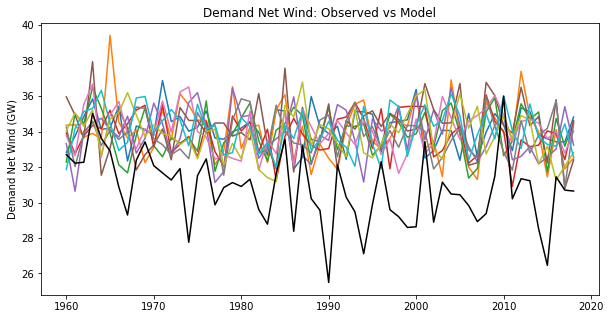

In [83]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# extract the observed index
index = obs_df["demand_net_wind"][:-1].index

# loop over the unique members
for member in model_df.index.get_level_values("member").unique():
    # plot the model data
    model_df_member = model_df.loc[model_df.index.get_level_values("member") == member]

    # extract the values
    values = model_df_member["demand_net_wind"].values

    # plot the model data
    plt.plot(index, values, label=f"Model Member {member}")

# extract the observed values
obs_values = obs_df["demand_net_wind"][:-1].values

# plot the observed data
plt.plot(index, obs_values, label="Observed", color="black")

# set the title
plt.title("Demand Net Wind: Observed vs Model")

# set the ylabel
plt.ylabel("Demand Net Wind (GW)")

Text(0.5, 1.0, 'Demand Net Wind: Observed vs Model Histograms')

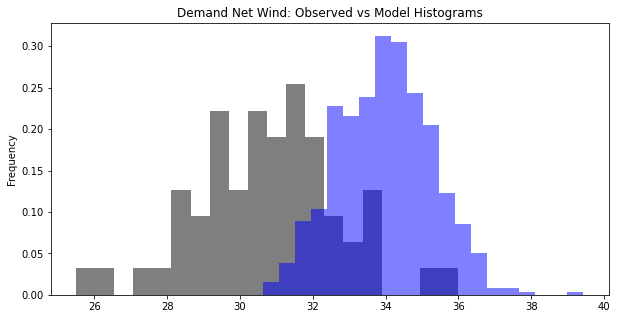

In [84]:
# Plot the histograms of demand net wind for demand net wind
# for the observed and model data
fig, ax = plt.subplots(figsize=(10, 5))

# plot the histogram of the observed data
obs_df["demand_net_wind"].plot.hist(
    ax=ax, bins=20, alpha=0.5, label="Observed", color="black", density=True
)

# loop over the unique members
model_df["demand_net_wind"].plot.hist(
    ax=ax, bins=20, alpha=0.5, label="Model", color="blue", density=True
)

# set the title
plt.title("Demand Net Wind: Observed vs Model Histograms")

In [85]:
obs_df.columns

Index(['United_Kingdom_t2m', 'United_Kingdom_hdd', 'United_Kingdom_cdd',
       'United_Kingdom_demand', 'obs_wind_speed_100m_bc', 'obs_cfs_ons',
       'obs_cfs_ofs', 'ons_gen', 'ofs_gen', 'ons_gen_anom', 'ofs_gen_anom',
       'colour_ons', 'colour_ofs', 'total_gen', 'total_gen_anom',
       'colour_total', 'demand_net_wind', 'demand_net_wind_anom'],
      dtype='object')

(0.0, 5.0)

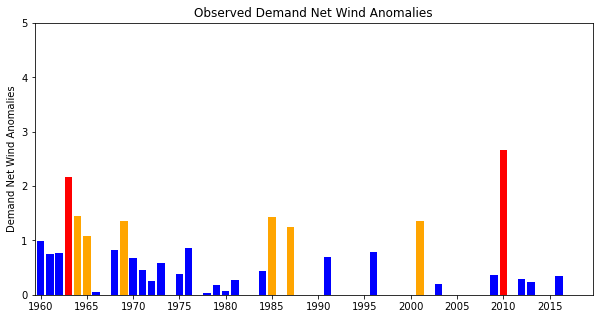

In [105]:
# Set up the positive conditions for demand net wind
positive_conditions_dnw_obs = [
    (obs_df["demand_net_wind_anom"] >= 0) & (obs_df["demand_net_wind_anom"] <= 1),
    (obs_df["demand_net_wind_anom"] >= 1) & (obs_df["demand_net_wind_anom"] <= 2),
    (obs_df["demand_net_wind_anom"] >= 2) & (obs_df["demand_net_wind_anom"] <= 3),
    (obs_df["demand_net_wind_anom"] > 3),
    (obs_df["demand_net_wind_anom"] < 0),
]

# Set up the labels for these
obs_df["colour_dnw"] = np.select(positive_conditions_dnw_obs, colors, default="black")

# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# plot the observed data as bars
obs_df["demand_net_wind_anom"].plot.bar(
    ax=ax, color=obs_df["colour_dnw"], label="Observed", width=0.8
)

# set up a horizontal line at 0
ax.axhline(0, color="black", linewidth=1)

# set the title
plt.title("Observed Demand Net Wind Anomalies")

# only plo the xlabels every 5 years
ax.set_xticks(ax.get_xticks()[::5])

# tilt the ticks to make them more readable
ax.tick_params(axis="x", rotation=360)

# set the ylabel
plt.ylabel("Demand Net Wind Anomalies")

# Set the ylims
ax.set_ylim(0, 5)


In [99]:
model_df.head()

,member,United_Kingdom_tas,United_Kingdom_hdd,United_Kingdom_cdd,United_Kingdom_demand,United_Kingdom_wind_power_cfs_ons,United_Kingdom_wind_power_cfs_ofs,ons_gen,ofs_gen,ons_gen_anom,ofs_gen_anom,colour_ons,colour_ofs,total_gen,total_gen_anom,colour_total,demand_net_wind,demand_net_wind_anom,colour_dnw
1960,1,5.206377,10.293623,0.0,42.751689,0.302699,0.366917,4.499927,5.414228,0.412977,0.491481,gray,gray,9.914155,0.815762,gray,32.837534,-0.886049,gray
1960,2,4.630105,10.869895,0.0,43.182515,0.268961,0.326913,3.998380,4.823929,-0.088570,-0.098818,blue,blue,8.822308,-0.169012,blue,34.360207,0.290022,blue
1960,3,4.810368,10.689632,0.0,43.047749,0.329829,0.397164,4.903244,5.860547,0.816295,0.937799,gray,gray,10.763791,1.582078,gray,32.283958,-1.313617,gray
1960,4,5.200538,10.299462,0.0,42.756054,0.269520,0.327850,4.006691,4.837756,-0.080258,-0.084991,blue,blue,8.844447,-0.149044,blue,33.911607,-0.056464,gray
1960,5,5.778914,9.721086,0.0,42.323655,0.275900,0.332092,4.101528,4.900346,0.014578,-0.022401,gray,blue,9.001874,-0.007055,blue,33.321781,-0.512030,gray


In [98]:
# make member a column again
model_df.reset_index(level="member", inplace=True)

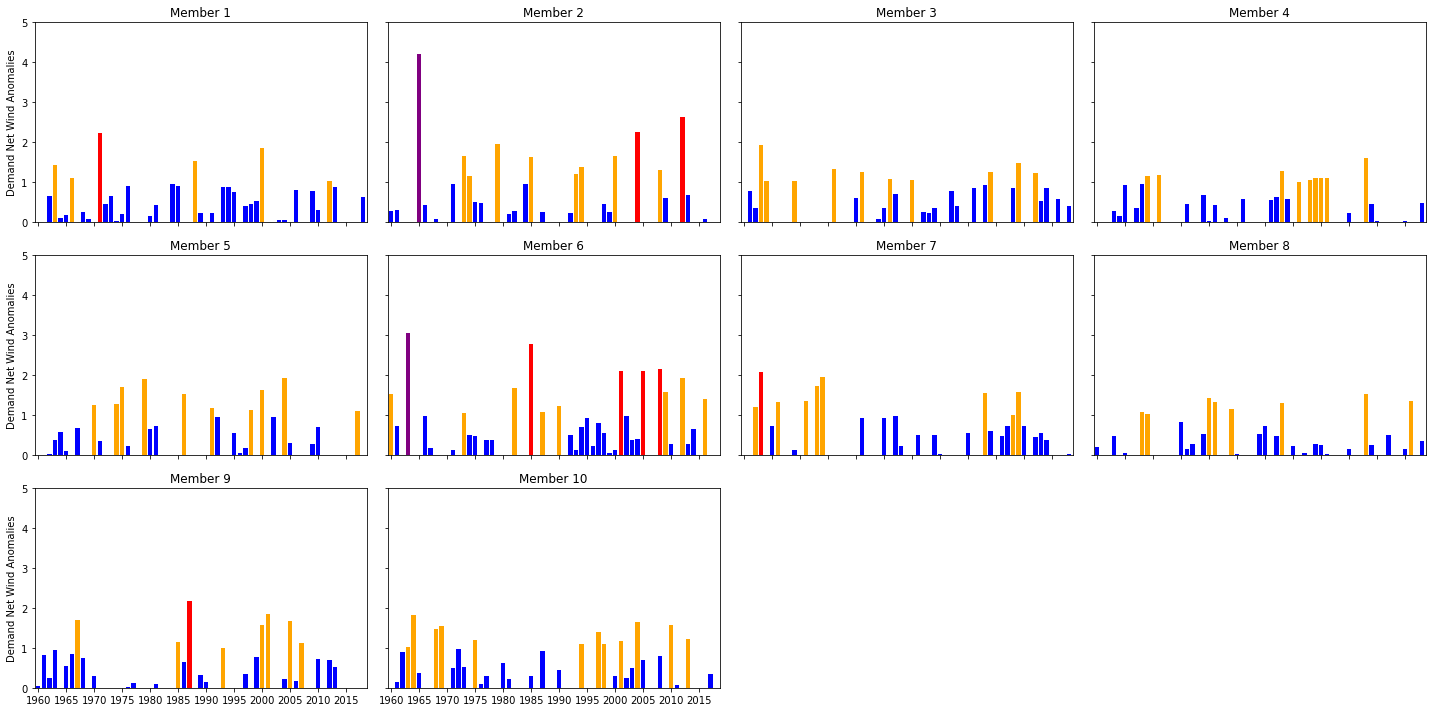

In [104]:
# Do the same but for all of the model members
# Set up the positive conditions for demand net wind
positive_conditions_dnw_model = [
    (model_df["demand_net_wind_anom"] >= 0) & (model_df["demand_net_wind_anom"] <= 1),
    (model_df["demand_net_wind_anom"] >= 1) & (model_df["demand_net_wind_anom"] <= 2),
    (model_df["demand_net_wind_anom"] >= 2) & (model_df["demand_net_wind_anom"] <= 3),
    (model_df["demand_net_wind_anom"] > 3),
    (model_df["demand_net_wind_anom"] < 0),
]

# Set up the colours for these
model_df["colour_dnw"] = np.select(positive_conditions_dnw_model, colors, default="black")

# Set up the figure with 3 rows and 4 columns
fig, axs = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

# Loop over the unique members in the model data
for member, ax in zip(model_df["member"].unique(), axs.flatten()):
    # plot the demand net wind anomalies
    model_df_member = model_df.loc[model_df["member"] == member]

    # plot the observed data as bars
    model_df_member["demand_net_wind_anom"].plot.bar(
        ax=ax,
        color=model_df_member["colour_dnw"],
        label=f"Model Member {member}",
        width=0.8,
    )

    # set up a horizontal line at 0
    ax.axhline(0, color="black", linewidth=1)

    # set the title
    ax.set_title(f"Member {member}")

    # only plo the xlabels every 5 years
    ax.set_xticks(ax.get_xticks()[::5])

    # tilt the ticks to make them more readable
    ax.tick_params(axis="x", rotation=360)

    # set the ylabel
    ax.set_ylabel("Demand Net Wind Anomalies")

    # set the ylims
    ax.set_ylim(0, 5)

# remove the subplots that are not used
for ax in axs.flatten()[len(model_df["member"].unique()) :]:
    fig.delaxes(ax)

# Specify a tight layout
plt.tight_layout()